In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import time
import os
import pandas as pd
from dataclasses import dataclass
from collections import namedtuple
import pyro
import optax
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata
import genjax
from genjax import grasp

key = jax.random.PRNGKey(314159)
console = genjax.pretty()
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name

console = genjax.pretty()
label_fontsize = 70  # Set the desired font size here

smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("1.8.6")

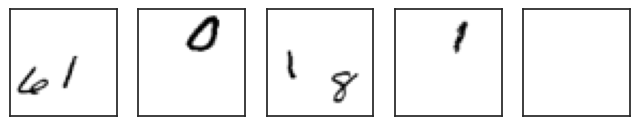

In [2]:
inpath = "./data/air/.data"
X_np, Y = multi_mnist.load(inpath)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = jnp.array(X_np)
true_counts = jnp.array([len(objs) for objs in Y])


def show_images(imgs):
    fig = plt.figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, len(imgs), i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, cmap="gray_r")


show_images(mnist[9:14])

## Defining the variational ingredients

### Utilities / learnable pieces

In [3]:
from genjax import Pytree
import equinox as eqx
from genjax.typing import Any
from genjax.typing import Tuple
from genjax.typing import FloatArray
from genjax.typing import Int
from genjax.typing import IntArray
from genjax.typing import PRNGKey
from genjax.typing import typecheck

# Utilities for defining the model and the guide.


@dataclass
class Decoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(50, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 400, key=key2)
        return Decoder(dense_1, dense_2)

    def __call__(self, z_what):
        v = self.dense_1(z_what)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return jax.nn.sigmoid(v)


# Create our decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
decoder = Decoder.new(sub_key1, sub_key2)

# Create our RNN for the guide.
key, sub_key = jax.random.split(key)
rnn = eqx.nn.LSTMCell(2554, 256, key=sub_key)


@dataclass
class Encoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(400, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 100, key=key2)
        return Encoder(dense_1, dense_2)

    def __call__(self, data):
        v = self.dense_1(data)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:50], jax.nn.softplus(v[50:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
encoder = Encoder.new(sub_key1, sub_key2)


@dataclass
class Predict(Pytree):
    dense: Any

    def flatten(self):
        return (self.dense,), ()

    @classmethod
    def new(cls, key):
        dense = eqx.nn.Linear(256, 7, key=key)
        return Predict(dense)

    def __call__(self, h):
        a = self.dense(h)
        z_pres_p = jax.nn.sigmoid(a[0:1])
        z_where_loc = a[1:4]
        z_where_scale = jax.nn.softplus(a[4:])
        return z_pres_p, z_where_loc, z_where_scale


key, sub_key = jax.random.split(key)
predict = Predict.new(key)

In [4]:
#######
# STN #
#######

# modified from https://github.com/kevinzakka/spatial-transformer-network/blob/master/stn/transformer.py


def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature
    map, will create an output feature map that is an
    affine transformation [1] of the input feature map.

    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample.

    - width: desired width of grid/output. Used
      to downsample or upsample.

    - theta: affine transform matrices of shape (num_batch, 2, 3).
      For each image in the batch, we have 6 theta parameters of
      the form (2x3) that define the affine transformation T.

    Returns
    -------
    - normalized grid (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the
      sampling points of the original image for each point in the
      target image.

    Note
    ----
    [1]: the affine transformation allows cropping, translation,
         and isotropic scaling.
    """
    num_batch = theta.shape[0]

    # create normalized 2D grid
    x = jnp.linspace(-1.0, 1.0, width)
    y = jnp.linspace(-1.0, 1.0, height)
    x_t, y_t = jnp.meshgrid(x, y)

    # flatten
    x_t_flat = jnp.reshape(x_t, [-1])
    y_t_flat = jnp.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = jnp.ones_like(x_t_flat)
    sampling_grid = jnp.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = jnp.expand_dims(sampling_grid, axis=0)
    sampling_grid = jnp.tile(sampling_grid, [num_batch, 1, 1])

    # transform the sampling grid - batch multiply
    batch_grids = jnp.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, 2, H, W)
    batch_grids = jnp.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids


def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the
    normalized coordinates provided by the sampling grid. Note that
    the sampling is done identically for each channel of the input.

    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.

    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.

    Returns
    -------
    - out: interpolated images according to grids. Same size as grid.
    """
    H = jnp.shape(img)[1]
    W = jnp.shape(img)[2]
    max_y = H - 1
    max_x = W - 1
    zero = jnp.zeros([], dtype=int)

    # rescale x and y to [0, W-1/H-1]
    x = 0.5 * ((x + 1.0) * max_x - 1)
    y = 0.5 * ((y + 1.0) * max_y - 1)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = jnp.floor(x).astype(int)
    x1 = x0 + 1
    y0 = jnp.floor(y).astype(int)
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = jnp.clip(x0, zero, max_x)
    x1 = jnp.clip(x1, zero, max_x)
    y0 = jnp.clip(y0, zero, max_y)
    y1 = jnp.clip(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = x0.astype(float)
    x1 = x1.astype(float)
    y0 = y0.astype(float)
    y1 = y1.astype(float)

    # calculate deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    # add dimension for addition
    wa = jnp.expand_dims(wa, axis=3)
    wb = jnp.expand_dims(wb, axis=3)
    wc = jnp.expand_dims(wc, axis=3)
    wd = jnp.expand_dims(wd, axis=3)

    # compute output
    out = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return out


def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.

    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W,)
    - y: flattened tensor of shape (B*H*W,)

    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    batch_size, height, width = jnp.shape(x)

    batch_idx = jnp.arange(0, batch_size)
    batch_idx = jnp.reshape(batch_idx, (batch_size, 1, 1))
    b = jnp.tile(batch_idx, (1, height, width))

    indices = jnp.stack([b, y, x], 3)

    return gather_nd(img, indices)


# from: https://github.com/google/jax/discussions/6119
def gather_nd_unbatched(params, indices):
    return params[tuple(jnp.moveaxis(indices, -1, 0))]


def gather_nd(params, indices, batch=False):
    if not batch:
        return gather_nd_unbatched(params, indices)
    else:
        return vmap(gather_nd_unbatched, (0, 0), 0)(params, indices)


def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = 1
    expansion_indices = jnp.array([1, 0, 2, 0, 1, 3])
    z_where = jnp.expand_dims(z_where, axis=0)
    out = jnp.concatenate((jnp.broadcast_to(jnp.zeros([1, 1]), (n, 1)), z_where), 1)
    return jnp.reshape(out[:, expansion_indices], (n, 2, 3))


def object_to_image(z_where, obj):
    n = 1
    theta = expand_z_where(z_where)
    grid = affine_grid_generator(50, 50, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(obj, (n, 20, 20, 1)), x_s, y_s)
    return jnp.reshape(out, (50, 50))


def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = 1
    out = jnp.array([1, *(-z_where[1:])])
    out = out / z_where[0]
    return out


def image_to_object(z_where, image):
    n = 1
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid_generator(20, 20, theta_inv)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(image, (n, 50, 50, 1)), x_s, y_s)
    return jnp.reshape(out, (400,))

### Model

In [5]:
#########
# Model #
#########

# Fixed constants.
z_where_prior_loc = jnp.array([3.0, 0.0, 0.0])
z_where_prior_scale = jnp.array([0.2, 1.0, 1.0])
z_what_prior_loc = jnp.zeros(50, dtype=float)
z_what_prior_scale = jnp.ones(50, dtype=float)
z_pres_prior = 0.003
eps = 1e-4


@genjax.gen
@typecheck
def step(
    t: Int,
    decoder: Decoder,
    prev_x: FloatArray,
    prev_z_pres: IntArray,
):
    z_pres = grasp.flip_reinforce(z_pres_prior ** (2 * t + 1)) @ f"z_pres_{t}"
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = (
        grasp.mv_normal_diag_reparam(z_where_prior_loc, z_where_prior_scale)
        @ f"z_where_{t}"
    )
    z_what = (
        grasp.mv_normal_diag_reparam(z_what_prior_loc, z_what_prior_scale)
        @ f"z_what_{t}"
    )
    y_att = decoder(z_what)
    y = object_to_image(z_where, y_att)
    x = prev_x + (y * z_pres)
    return x, z_pres


# TODO: Make sure that this works, where t is a static int.
@genjax.gen
@typecheck
def model(decoder: Decoder):
    x = jnp.zeros((50, 50), dtype=float)
    z_pres = jnp.ones(1, dtype=int)
    for t in range(3):
        x, z_pres = step.inline(t, decoder, x, z_pres)
    obs = grasp.mv_normal_diag_reparam(x, 0.3 * jnp.ones_like(x)) @ "obs"
    return x

#### Samples from the model

In [6]:
tr = jax.jit(model.simulate)(key, (decoder,))
tr.strip()




├── :z_what_0
│   └──  f32[50]
├── :z_where_2
│   └──  f32[3]
├── :z_what_1
│   └──  f32[50]
├── :z_pres_2
│   └──  bool[]
├── :obs
│   └──  f32[50,50]
├── :z_pres_1
│   └──  bool[]
├── :z_what_2
│   └──  f32[50]
├── :z_pres_0
│   └──  bool[]
├── :z_where_1
│   └──  f32[3]
└── :z_where_0
    └──  f32[3]

### Guide

In [7]:
#########
# Guide #
#########


@genjax.gen
@typecheck
def guide_step(
    t: Int,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
    data,
    prev: Tuple,
):
    (prev_z_where, prev_z_what, prev_z_pres, prev_h, prev_c) = prev
    rnn_input = jnp.concatenate([data, prev_z_where, prev_z_what, prev_z_pres])
    h, c = rnn(rnn_input, (prev_h, prev_c))
    z_pres_p, z_where_loc, z_where_scale = predict(h)
    z_pres = (
        grasp.flip_reinforce((eps + (z_pres_p[0] * prev_z_pres[0])) / (1 + 2 * eps))
        @ f"z_pres_{t}"
    )
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = grasp.mv_normal_diag_reparam(z_where_loc, z_where_scale) @ f"z_where_{t}"
    x_att = image_to_object(z_where, data)
    z_what_loc, z_what_scale = encoder(x_att)
    z_what = grasp.mv_normal_diag_reparam(z_what_loc, z_what_scale) @ f"z_what_{t}"
    return z_where, z_what, z_pres, h, c


@genjax.gen
@typecheck
def guide(
    data: genjax.ChoiceMap,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
):
    h = jnp.zeros(256)
    c = jnp.zeros(256)
    z_pres = jnp.ones(1)
    z_where = jnp.zeros(3)
    z_what = jnp.zeros(50)
    img = data["obs"]
    img_arr = img.flatten()

    for t in range(3):
        (z_where, z_what, z_pres, h, c) = guide_step.inline(
            t, rnn, encoder, predict, img_arr, (z_where, z_what, z_pres, h, c)
        )

#### Samples from the guide

In [8]:
data_chm = genjax.choice_map({"obs": jnp.ones((50, 50))})
tr = jax.jit(guide.simulate)(key, (data_chm, rnn, encoder, predict))
tr.strip()




├── :z_what_0
│   └──  f32[50]
├── :z_where_2
│   └──  f32[3]
├── :z_what_1
│   └──  f32[50]
├── :z_pres_2
│   └──  bool[]
├── :z_pres_1
│   └──  bool[]
├── :z_what_2
│   └──  f32[50]
├── :z_pres_0
│   └──  bool[]
├── :z_where_1
│   └──  f32[3]
└── :z_where_0
    └──  f32[3]

## Training

### Make sure grads are working

#### Define ELBO objective

In [9]:
data = genjax.choice_map({"obs": jnp.ones((50, 50))})
objective = grasp.elbo(model, guide, data)

#### Go go grads

In [10]:
jitted = jax.jit(objective.value_and_grad_estimate)
loss, ((decoder_grads,), (_, rnn_grads, encoder_grads, predict_grads)) = jitted(
    key, ((decoder,), (data, rnn, encoder, predict))
)

In [11]:
loss

Array(-13631.901, dtype=float32)

### Dataloader

In [12]:
def data_loader(
    data,
    batch_size,
    shuffle=True,
):
    N = len(data)
    data_idxs = np.arange(N)
    num_batch = int(np.ceil(N // batch_size))

    def init(key):
        return (
            num_batch,
            jax.random.permutation(key, data_idxs) if shuffle else data_idxs,
        )

    def get_batch(i=0, idxs=data_idxs):
        ret_idx = jax.lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
        return jax.lax.index_take(data, (ret_idx,), axes=(0,))

    return init, get_batch

In [13]:
##################
# Count Accuracy #
##################


def count_accuracy(data, true_counts, guide, batch_size=1000):
    global prng_key
    assert data.shape[0] == true_counts.shape[0], "Size mismatch."
    assert data.shape[0] % batch_size == 0, "Input size must be multiple of batch_size."

    def eval_guide(key, data, params):
        data_chmp = genjax.choice_map({"obs": data})
        return guide.simulate(key, (data_chmp, *params))

    batch_eval_guide = jax.vmap(eval_guide, in_axes=(0, 0, None))

    @jax.jit
    def evaluate_count_accuracy(key, params):
        def evaluate_batch(counts, batch_id):
            data_batch = jax.lax.dynamic_slice_in_dim(
                data, batch_id * batch_size, batch_size
            )
            true_counts_batch = jax.lax.dynamic_slice_in_dim(
                true_counts, batch_id * batch_size, batch_size
            )
            data_chmp = genjax.choice_map({"obs": data_batch})
            # evaluate guide
            keys = jax.random.split(jax.random.fold_in(key, batch_id), batch_size)
            tr = batch_eval_guide(keys, data_batch, params)
            z_where = [tr[f"z_where_{i}"] for i in range(3)]
            z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
            # compute stats
            inferred_counts = sum(z for z in z_pres)
            true_counts_m = jax.nn.one_hot(true_counts_batch, 3)
            inferred_counts_m = jax.nn.one_hot(inferred_counts, 4)
            counts += (true_counts_m.T @ inferred_counts_m).astype(int)
            error_ind = 1 - (true_counts_batch == inferred_counts).astype(int)
            # error_ix = error_ind.nonzero()[0]
            # error_latent = jnp.take(latents_to_tensor((z_where, z_pres)), error_ix, 0)
            return counts, error_ind

        counts = jnp.zeros((3, 4), dtype=int)
        counts, error_indices = jax.lax.scan(
            evaluate_batch, counts, jnp.arange(data.shape[0] // batch_size)
        )

        acc = jnp.sum(jnp.diag(counts)).astype(float) / data.shape[0]
        error_indices = jnp.concatenate(
            error_indices
        )  # .nonzero()[0]  # <- not JIT compilable
        return acc, counts, error_indices

    return evaluate_count_accuracy


# Combine z_pres and z_where (as returned by the model and guide) into
# a single tensor, with size:
# [batch_size, num_steps, z_where_size + z_pres_size]
def latents_to_tensor(z):
    return jnp.stack(
        [
            jnp.concatenate((z_where, z_pres.reshape(-1, 1)), 1)
            for z_where, z_pres in zip(*z)
        ]
    ).transpose(1, 0, 2)

In [14]:
##################
# Visualization  #
##################


def bounding_box(z_where, x_size):
    """This doesn't take into account interpolation, but it's close
    enough to be usable."""
    w = x_size / z_where.s
    h = x_size / z_where.s
    xtrans = -z_where.x / z_where.s * x_size / 2.0
    ytrans = -z_where.y / z_where.s * x_size / 2.0
    x = (x_size - w) / 2 + xtrans  # origin is top left
    y = (x_size - h) / 2 + ytrans
    return (x, y), w, h


z_obj = namedtuple("z", ["s", "x", "y", "pres"])


# Map a tensor of latents (as produced by latents_to_tensor) to a list
# of z_obj named tuples.
def tensor_to_objs(latents):
    return [[z_obj._make(step) for step in z] for z in latents]


def visualize_model(model, guide):
    def reconstruct_digits(key, data, params):
        decoder, rnn, encoder, predict = params
        data_chmp = genjax.choice_map({"obs": data})
        key1, key2 = jax.random.split(key)
        tr = guide.simulate(key1, (data_chmp, rnn, encoder, predict))
        _, tr = model.importance(key2, tr, (decoder,))
        reconstruction = tr.get_retval()
        z_where = [tr[f"z_where_{i}"] for i in range(3)]
        z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
        return reconstruction, (z_where, z_pres)

    batch_reconstruct_digits = jax.jit(
        jax.vmap(reconstruct_digits, in_axes=(0, 0, None))
    )

    def visualize(key, params, examples_to_viz):
        keys = jax.random.split(key, examples_to_viz.shape[0])
        recons, z = batch_reconstruct_digits(keys, examples_to_viz, params)
        z_wheres = tensor_to_objs(latents_to_tensor(z))
        draw_many(examples_to_viz.reshape(-1, 50, 50), z_wheres, title="Original")
        draw_many(recons, z_wheres, title="Reconstruction")

    return visualize


def colors(k):
    return ["r", "g", "b"][k % 3]


def draw_one(img, z):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray_r")
    for k, z in enumerate(z):
        if z.pres > 0:
            (x, y), w, h = bounding_box(z, img.shape[0])
            plt.gca().add_patch(
                Rectangle(
                    (x, y), w, h, linewidth=1, edgecolor=colors(k), facecolor="none"
                )
            )


def draw_many(imgs, zs, title):
    plt.figure(figsize=(8, 1.9))
    plt.title(title)
    plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    plt.box(False)
    for i, (img, z) in enumerate(zip(imgs, zs)):
        plt.subplot(1, len(imgs), i + 1)
        draw_one(img, z)
    plt.show()

In [15]:
params = (decoder, rnn, encoder, predict)
evaluate_accuracy = count_accuracy(mnist, true_counts, guide, batch_size=1000)

visualize_examples = mnist[5:10]
visualize = visualize_model(model, guide)

In [16]:
def train(key, n=1, num_epochs=200, batch_size=64, learning_rate=1.0e-4):
    def svi_update(model, guide, optimiser):
        def batch_updater(key, params, opt_state, data_batch):
            def grads(key, params, data):
                (decoder, rnn, encoder, predict) = params
                data = genjax.choice_map({"obs": data})
                objective = grasp.iwae_elbo(model, guide, data, n)
                loss, (
                    (decoder_grads,),
                    (_, rnn_grads, encoder_grads, predict_grads),
                ) = objective.value_and_grad_estimate(
                    key, ((decoder,), (data, rnn, encoder, predict))
                )
                return loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads)

            sub_keys = jax.random.split(key, len(data_batch))
            loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads) = jax.vmap(
                grads, in_axes=(0, None, 0)
            )(sub_keys, params, data_batch)

            grads = jtu.tree_map(
                lambda v: -1.0 * jnp.mean(v, axis=0),
                (decoder_grads, rnn_grads, encoder_grads, predict_grads),
            )
            updates, opt_state = optimiser.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            loss = jnp.mean(loss)
            return params, opt_state, loss

        return batch_updater

    adam = optax.adam(learning_rate)
    svi_updater = svi_update(model, guide, adam)
    train_init, train_fetch = data_loader(jnp.array(mnist), batch_size)
    key, sub_key = jax.random.split(key)
    num_batch, train_idx = train_init(sub_key)

    @jax.jit
    def epoch_train(opt_state, params, key, train_idx):
        def body_fn(carry, xs):
            idx, params, opt_state, loss = carry
            updater_key = jax.random.fold_in(key, idx)
            batch = train_fetch(idx, train_idx)
            params, opt_state, loss = svi_updater(updater_key, params, opt_state, batch)
            idx += 1
            return (idx, params, opt_state, loss), loss

        idx = 0
        (_, params, opt_state, _), losses = jax.lax.scan(
            body_fn, (idx, params, opt_state, 0.0), None, length=num_batch
        )
        return params, opt_state, losses

    # Train.
    params = (decoder, rnn, encoder, predict)
    opt_state = adam.init(params)
    losses = []
    accuracy = []
    wall_clock_times = []

    # Warm up.
    _ = epoch_train(opt_state, params, key, train_idx)

    t0 = time.perf_counter()
    acc_time = 0.0
    for i in range(0, num_epochs + 1):
        key, sub_key = jax.random.split(key)
        num_batch, train_idx = train_init(sub_key)
        key, sub_key = jax.random.split(key)
        start = time.perf_counter() - t0
        params, opt_state, loss = epoch_train(opt_state, params, sub_key, train_idx)
        stop = time.perf_counter() - t0
        acc_time += stop - start
        wall_clock_times.append(acc_time)
        print(
            f"Epoch={i}, total_epoch_step_time={acc_time:.2f}, loss={jnp.mean(loss):.2f}"
        )
        losses.append(jnp.mean(loss))
        acc, counts, error_ix = evaluate_accuracy(sub_key, params[1:])
        accuracy.append(acc)
        if i % 10 == 0:
            print("accuracy={}, counts={}".format(acc, counts))
            visualize(sub_key, params, visualize_examples)

    return losses, accuracy, wall_clock_times, params

Epoch=0, total_epoch_step_time=1.28, loss=-80.35
accuracy=0.242249995470047, counts=[[11164  7440  1300    44]
 [16567  3356    96     1]
 [18832  1185    15     0]]


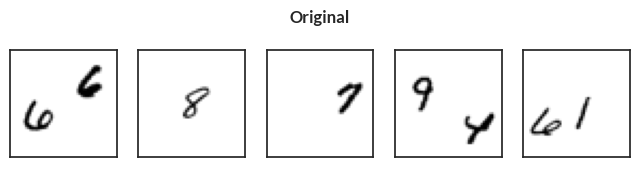

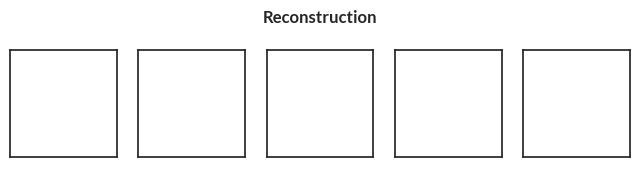

Epoch=1, total_epoch_step_time=2.69, loss=398.76
Epoch=2, total_epoch_step_time=4.09, loss=419.48
Epoch=3, total_epoch_step_time=5.47, loss=437.93
Epoch=4, total_epoch_step_time=6.88, loss=451.01
Epoch=5, total_epoch_step_time=8.30, loss=455.91
Epoch=6, total_epoch_step_time=9.66, loss=457.39
Epoch=7, total_epoch_step_time=11.14, loss=458.41
Epoch=8, total_epoch_step_time=12.71, loss=459.10
Epoch=9, total_epoch_step_time=14.23, loss=459.39
Epoch=10, total_epoch_step_time=15.74, loss=459.51
accuracy=0.27853333950042725, counts=[[14848  4925   175     0]
 [18125  1859    36     0]
 [19179   848     5     0]]


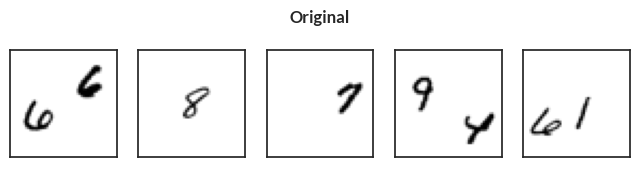

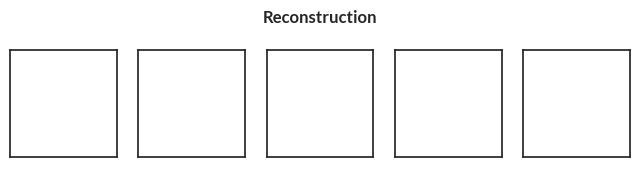

Epoch=11, total_epoch_step_time=17.28, loss=459.63
Epoch=12, total_epoch_step_time=18.78, loss=459.71
Epoch=13, total_epoch_step_time=20.32, loss=459.70
Epoch=14, total_epoch_step_time=21.92, loss=459.67
Epoch=15, total_epoch_step_time=23.58, loss=459.66
Epoch=16, total_epoch_step_time=25.15, loss=459.69
Epoch=17, total_epoch_step_time=26.64, loss=459.80
Epoch=18, total_epoch_step_time=28.18, loss=460.14
Epoch=19, total_epoch_step_time=29.76, loss=460.97
Epoch=20, total_epoch_step_time=31.25, loss=464.41
accuracy=0.40601667761802673, counts=[[15086  4820    42     0]
 [11913  7128   881    98]
 [ 8765  8606  2147   514]]


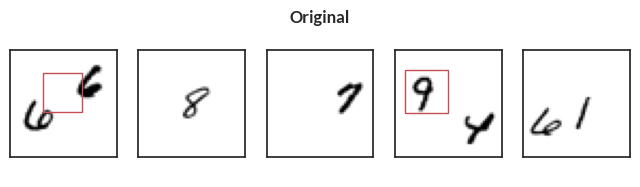

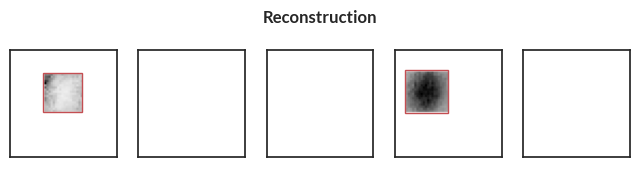

Epoch=21, total_epoch_step_time=32.73, loss=474.64
Epoch=22, total_epoch_step_time=34.23, loss=497.45
Epoch=23, total_epoch_step_time=35.79, loss=512.20
Epoch=24, total_epoch_step_time=37.51, loss=520.76
Epoch=25, total_epoch_step_time=39.17, loss=527.63
Epoch=26, total_epoch_step_time=40.65, loss=536.72
Epoch=27, total_epoch_step_time=42.11, loss=545.62
Epoch=28, total_epoch_step_time=43.65, loss=553.45
Epoch=29, total_epoch_step_time=45.16, loss=559.64
Epoch=30, total_epoch_step_time=46.68, loss=565.11
accuracy=0.8173166513442993, counts=[[16405  3542     1     0]
 [  294 17606  2113     7]
 [   11  4381 15028   612]]


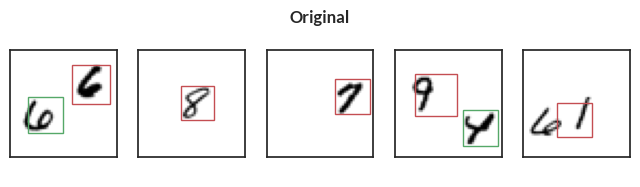

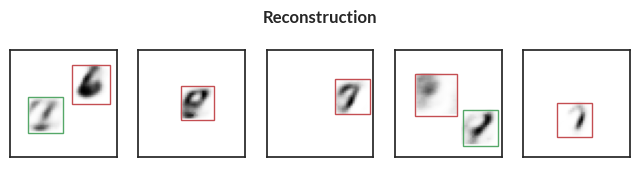

Epoch=31, total_epoch_step_time=48.19, loss=569.63
Epoch=32, total_epoch_step_time=49.69, loss=572.55
Epoch=33, total_epoch_step_time=51.21, loss=576.61
Epoch=34, total_epoch_step_time=52.73, loss=580.32
Epoch=35, total_epoch_step_time=54.27, loss=582.96
Epoch=36, total_epoch_step_time=55.76, loss=585.03
Epoch=37, total_epoch_step_time=57.28, loss=587.89
Epoch=38, total_epoch_step_time=58.82, loss=590.20
Epoch=39, total_epoch_step_time=60.33, loss=591.25
Epoch=40, total_epoch_step_time=61.83, loss=591.49
accuracy=0.7755500078201294, counts=[[17805  2143     0     0]
 [   87 10717  9160    56]
 [    2   373 18011  1646]]


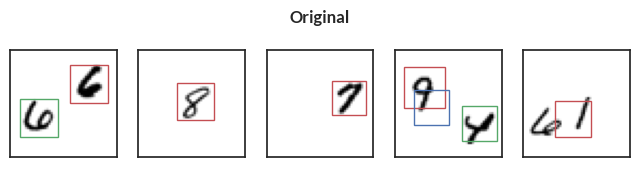

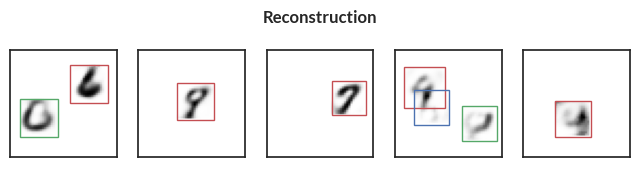

Epoch=41, total_epoch_step_time=63.33, loss=594.06
Epoch=42, total_epoch_step_time=64.83, loss=596.04
Epoch=43, total_epoch_step_time=66.28, loss=597.57
Epoch=44, total_epoch_step_time=67.80, loss=597.86
Epoch=45, total_epoch_step_time=69.31, loss=599.97
Epoch=46, total_epoch_step_time=70.83, loss=599.92
Epoch=47, total_epoch_step_time=72.41, loss=601.20
Epoch=48, total_epoch_step_time=73.91, loss=602.09
Epoch=49, total_epoch_step_time=75.43, loss=603.17
Epoch=50, total_epoch_step_time=76.94, loss=604.98
accuracy=0.9116833209991455, counts=[[19182   766     0     0]
 [  115 16721  3181     3]
 [    5  1050 18798   179]]


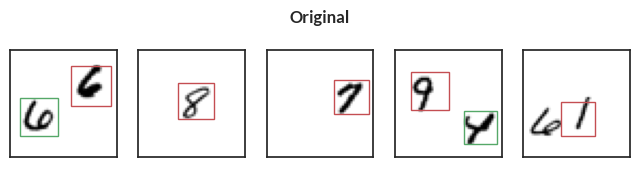

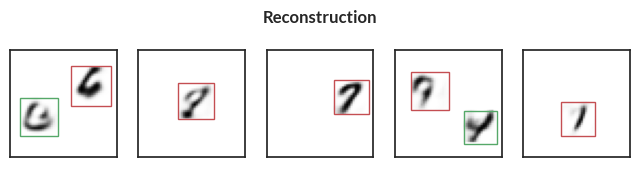

Epoch=51, total_epoch_step_time=78.47, loss=606.19
Epoch=52, total_epoch_step_time=80.00, loss=606.52
Epoch=53, total_epoch_step_time=81.50, loss=607.63
Epoch=54, total_epoch_step_time=82.98, loss=608.83
Epoch=55, total_epoch_step_time=84.51, loss=609.27
Epoch=56, total_epoch_step_time=86.03, loss=609.96
Epoch=57, total_epoch_step_time=87.55, loss=610.42
Epoch=58, total_epoch_step_time=89.04, loss=610.91
Epoch=59, total_epoch_step_time=90.59, loss=611.78
Epoch=60, total_epoch_step_time=92.08, loss=612.82
accuracy=0.9298166632652283, counts=[[19595   352     1     0]
 [   92 17686  2241     1]
 [    3  1467 18508    54]]


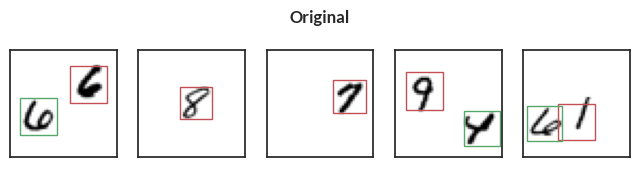

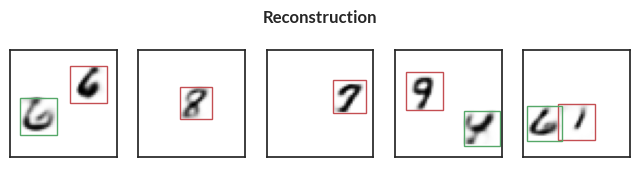

Epoch=61, total_epoch_step_time=93.58, loss=613.47
Epoch=62, total_epoch_step_time=95.12, loss=614.19
Epoch=63, total_epoch_step_time=96.65, loss=614.79
Epoch=64, total_epoch_step_time=98.15, loss=615.20
Epoch=65, total_epoch_step_time=99.64, loss=615.89
Epoch=66, total_epoch_step_time=101.17, loss=616.25
Epoch=67, total_epoch_step_time=102.67, loss=616.58
Epoch=68, total_epoch_step_time=104.18, loss=617.37
Epoch=69, total_epoch_step_time=105.72, loss=617.83
Epoch=70, total_epoch_step_time=107.31, loss=617.25
accuracy=0.9347833395004272, counts=[[19803   145     0     0]
 [   88 18841  1091     0]
 [    0  2566 17443    23]]


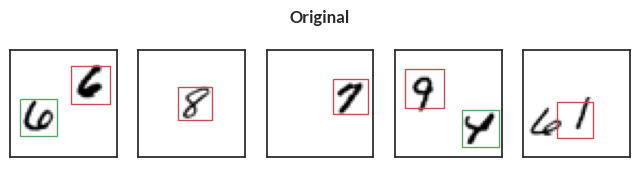

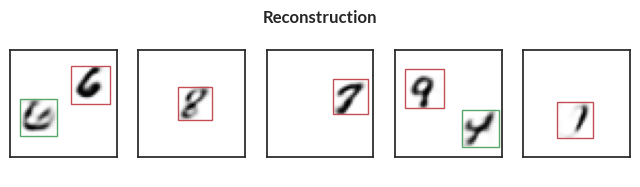

Epoch=71, total_epoch_step_time=108.87, loss=618.05
Epoch=72, total_epoch_step_time=110.44, loss=617.24
Epoch=73, total_epoch_step_time=111.92, loss=617.73
Epoch=74, total_epoch_step_time=113.44, loss=618.35
Epoch=75, total_epoch_step_time=114.95, loss=618.63
Epoch=76, total_epoch_step_time=116.41, loss=619.54
Epoch=77, total_epoch_step_time=117.90, loss=619.58
Epoch=78, total_epoch_step_time=119.40, loss=619.97
Epoch=79, total_epoch_step_time=120.91, loss=620.14
Epoch=80, total_epoch_step_time=122.36, loss=620.79
accuracy=0.9221000075340271, counts=[[19868    80     0     0]
 [   57 16085  3876     2]
 [    0   593 19373    66]]


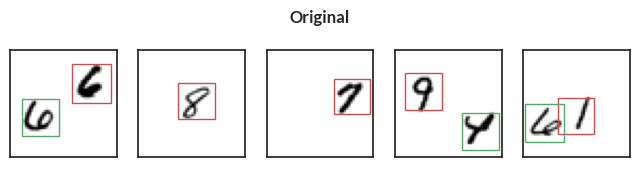

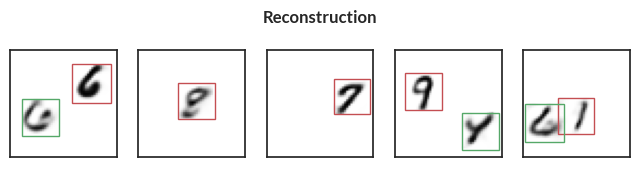

Epoch=81, total_epoch_step_time=123.94, loss=620.93
Epoch=82, total_epoch_step_time=125.51, loss=621.13
Epoch=83, total_epoch_step_time=127.04, loss=620.99
Epoch=84, total_epoch_step_time=128.55, loss=622.02
Epoch=85, total_epoch_step_time=130.03, loss=620.49
Epoch=86, total_epoch_step_time=131.53, loss=621.59
Epoch=87, total_epoch_step_time=133.05, loss=622.22
Epoch=88, total_epoch_step_time=134.52, loss=622.36
Epoch=89, total_epoch_step_time=136.17, loss=622.73
Epoch=90, total_epoch_step_time=137.64, loss=622.64
accuracy=0.9538500308990479, counts=[[19904    44     0     0]
 [   67 19071   882     0]
 [    3  1749 18256    24]]


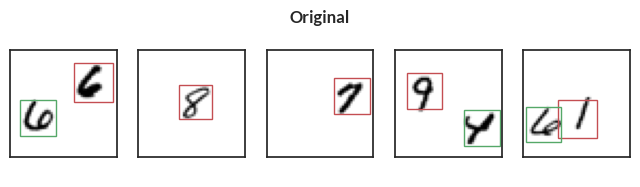

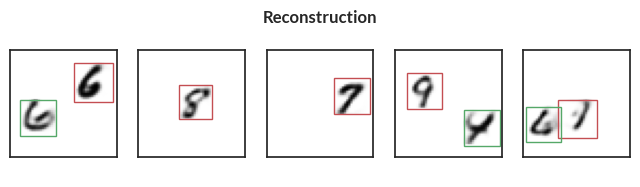

Epoch=91, total_epoch_step_time=139.14, loss=622.84
Epoch=92, total_epoch_step_time=140.67, loss=623.30
Epoch=93, total_epoch_step_time=142.19, loss=623.10
Epoch=94, total_epoch_step_time=143.66, loss=623.01
Epoch=95, total_epoch_step_time=145.16, loss=622.72
Epoch=96, total_epoch_step_time=146.67, loss=619.61
Epoch=97, total_epoch_step_time=148.17, loss=621.64
Epoch=98, total_epoch_step_time=149.70, loss=623.03
Epoch=99, total_epoch_step_time=151.23, loss=623.22
Epoch=100, total_epoch_step_time=152.73, loss=623.74
accuracy=0.9533500075340271, counts=[[19905    43     0     0]
 [   56 18467  1497     0]
 [    0  1150 18829    53]]


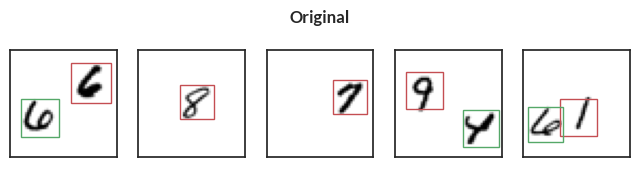

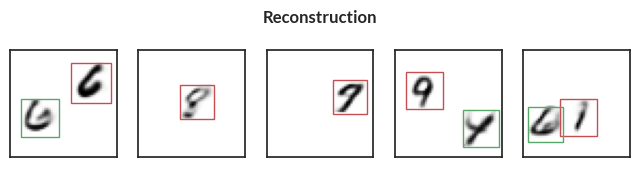

Epoch=101, total_epoch_step_time=154.28, loss=624.20
Epoch=102, total_epoch_step_time=155.79, loss=624.42
Epoch=103, total_epoch_step_time=157.30, loss=624.53
Epoch=104, total_epoch_step_time=158.87, loss=624.87
Epoch=105, total_epoch_step_time=160.40, loss=624.67
Epoch=106, total_epoch_step_time=161.94, loss=624.09
Epoch=107, total_epoch_step_time=163.41, loss=624.24
Epoch=108, total_epoch_step_time=164.87, loss=624.42
Epoch=109, total_epoch_step_time=166.42, loss=625.17
Epoch=110, total_epoch_step_time=167.93, loss=625.41
accuracy=0.9525333642959595, counts=[[19920    28     0     0]
 [   51 18696  1273     0]
 [    3  1465 18536    28]]


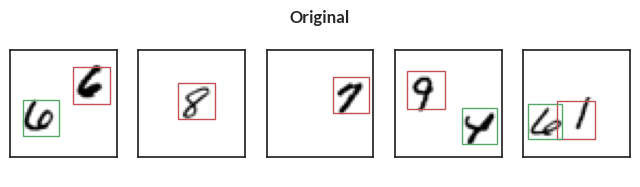

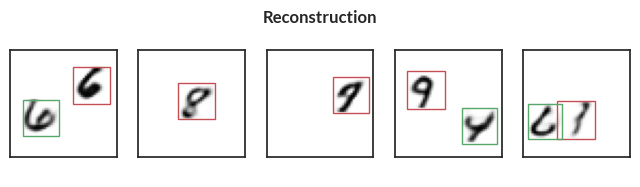

Epoch=111, total_epoch_step_time=169.47, loss=625.19
Epoch=112, total_epoch_step_time=171.02, loss=626.16
Epoch=113, total_epoch_step_time=172.52, loss=625.68
Epoch=114, total_epoch_step_time=174.02, loss=625.45
Epoch=115, total_epoch_step_time=175.56, loss=625.02
Epoch=116, total_epoch_step_time=177.16, loss=624.30
Epoch=117, total_epoch_step_time=178.74, loss=625.55
Epoch=118, total_epoch_step_time=180.26, loss=625.44
Epoch=119, total_epoch_step_time=181.84, loss=626.24
Epoch=120, total_epoch_step_time=183.42, loss=626.39
accuracy=0.9436833262443542, counts=[[19916    32     0     0]
 [   37 17520  2463     0]
 [    2   800 19185    45]]


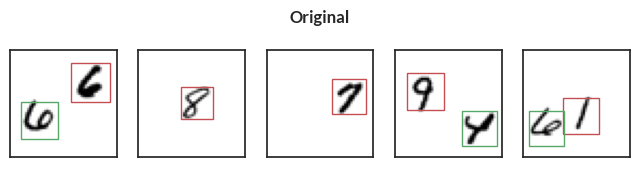

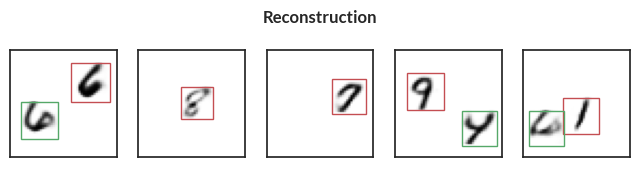

Epoch=121, total_epoch_step_time=184.92, loss=625.32
Epoch=122, total_epoch_step_time=186.51, loss=626.47
Epoch=123, total_epoch_step_time=188.03, loss=626.27
Epoch=124, total_epoch_step_time=189.57, loss=626.80
Epoch=125, total_epoch_step_time=191.10, loss=626.79
Epoch=126, total_epoch_step_time=192.67, loss=626.87
Epoch=127, total_epoch_step_time=194.25, loss=627.37
Epoch=128, total_epoch_step_time=195.76, loss=627.28
Epoch=129, total_epoch_step_time=197.30, loss=626.87
Epoch=130, total_epoch_step_time=198.84, loss=626.12
accuracy=0.938966691493988, counts=[[19930    18     0     0]
 [   34 17219  2765     2]
 [    1   779 19189    63]]


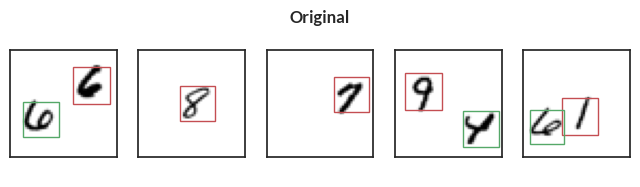

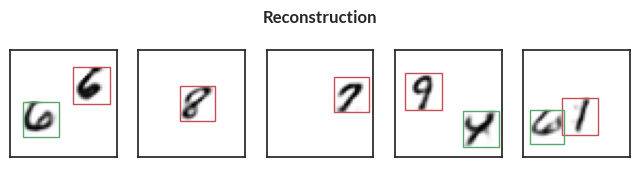

Epoch=131, total_epoch_step_time=200.37, loss=627.27
Epoch=132, total_epoch_step_time=201.91, loss=627.66
Epoch=133, total_epoch_step_time=203.46, loss=627.95
Epoch=134, total_epoch_step_time=204.97, loss=628.38
Epoch=135, total_epoch_step_time=206.53, loss=627.95
Epoch=136, total_epoch_step_time=208.14, loss=627.88
Epoch=137, total_epoch_step_time=209.67, loss=628.02
Epoch=138, total_epoch_step_time=211.18, loss=625.78
Epoch=139, total_epoch_step_time=212.70, loss=627.27
Epoch=140, total_epoch_step_time=214.21, loss=627.83
accuracy=0.9536499977111816, counts=[[19926    22     0     0]
 [   31 18068  1920     1]
 [    0   771 19225    36]]


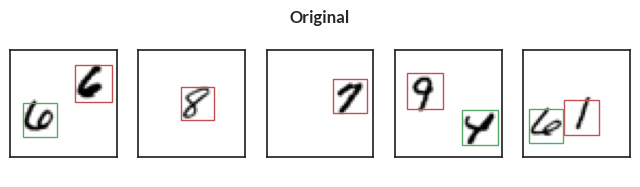

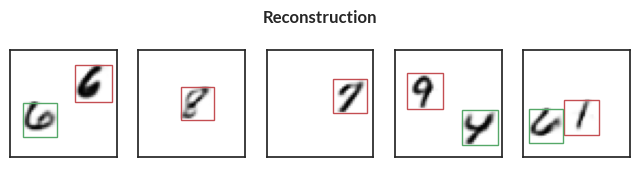

Epoch=141, total_epoch_step_time=215.71, loss=628.69
Epoch=142, total_epoch_step_time=217.20, loss=628.91
Epoch=143, total_epoch_step_time=218.71, loss=628.46
Epoch=144, total_epoch_step_time=220.16, loss=626.99
Epoch=145, total_epoch_step_time=221.68, loss=627.80
Epoch=146, total_epoch_step_time=223.15, loss=628.85
Epoch=147, total_epoch_step_time=224.72, loss=628.73
Epoch=148, total_epoch_step_time=226.22, loss=628.84
Epoch=149, total_epoch_step_time=227.74, loss=629.24
Epoch=150, total_epoch_step_time=229.25, loss=629.42
accuracy=0.9558666944503784, counts=[[19933    15     0     0]
 [   32 18242  1746     0]
 [    4   810 19177    41]]


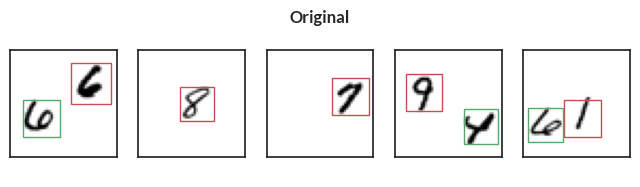

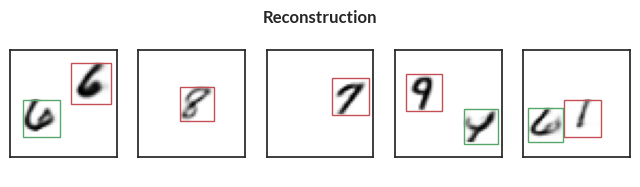

Epoch=151, total_epoch_step_time=230.82, loss=629.26
Epoch=152, total_epoch_step_time=232.30, loss=628.99
Epoch=153, total_epoch_step_time=233.83, loss=628.75
Epoch=154, total_epoch_step_time=235.26, loss=629.20
Epoch=155, total_epoch_step_time=236.86, loss=629.38
Epoch=156, total_epoch_step_time=238.35, loss=629.33
Epoch=157, total_epoch_step_time=239.88, loss=629.63
Epoch=158, total_epoch_step_time=241.43, loss=629.54
Epoch=159, total_epoch_step_time=242.92, loss=629.61
Epoch=160, total_epoch_step_time=244.45, loss=628.18
accuracy=0.9444167017936707, counts=[[19928    20     0     0]
 [   24 17303  2693     0]
 [    2   557 19434    39]]


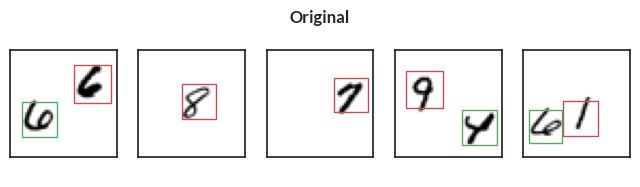

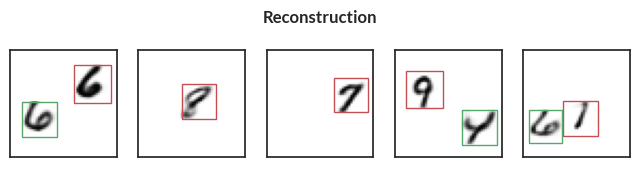

Epoch=161, total_epoch_step_time=246.02, loss=628.64
Epoch=162, total_epoch_step_time=247.50, loss=629.55
Epoch=163, total_epoch_step_time=249.02, loss=629.44
Epoch=164, total_epoch_step_time=250.53, loss=630.00
Epoch=165, total_epoch_step_time=252.06, loss=630.15
Epoch=166, total_epoch_step_time=253.56, loss=630.29
Epoch=167, total_epoch_step_time=255.18, loss=630.57
Epoch=168, total_epoch_step_time=256.71, loss=630.48
Epoch=169, total_epoch_step_time=258.24, loss=630.68
Epoch=170, total_epoch_step_time=259.86, loss=629.25
accuracy=0.9470000267028809, counts=[[19938    10     0     0]
 [   13 17497  2510     0]
 [    4   609 19385    34]]


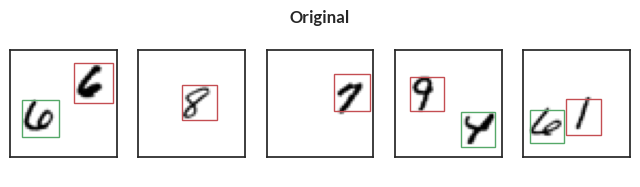

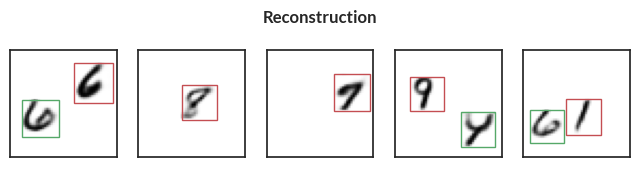

Epoch=171, total_epoch_step_time=261.50, loss=628.31
Epoch=172, total_epoch_step_time=263.16, loss=628.39
Epoch=173, total_epoch_step_time=264.78, loss=628.93
Epoch=174, total_epoch_step_time=266.32, loss=630.50
Epoch=175, total_epoch_step_time=268.01, loss=630.53
Epoch=176, total_epoch_step_time=269.71, loss=630.14
Epoch=177, total_epoch_step_time=271.23, loss=629.92
Epoch=178, total_epoch_step_time=272.73, loss=630.37
Epoch=179, total_epoch_step_time=274.31, loss=630.45
Epoch=180, total_epoch_step_time=275.82, loss=630.21
accuracy=0.9638000130653381, counts=[[19939     9     0     0]
 [   24 19387   609     0]
 [    1  1521 18502     8]]


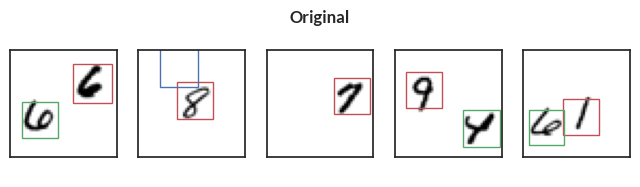

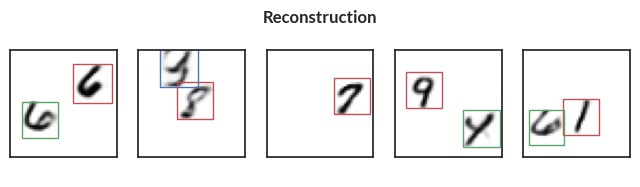

Epoch=181, total_epoch_step_time=277.26, loss=631.04
Epoch=182, total_epoch_step_time=278.87, loss=630.83
Epoch=183, total_epoch_step_time=280.39, loss=630.65
Epoch=184, total_epoch_step_time=281.93, loss=630.63
Epoch=185, total_epoch_step_time=283.48, loss=631.26
Epoch=186, total_epoch_step_time=285.04, loss=629.88
Epoch=187, total_epoch_step_time=286.58, loss=630.30
Epoch=188, total_epoch_step_time=288.09, loss=630.81
Epoch=189, total_epoch_step_time=289.66, loss=630.39
Epoch=190, total_epoch_step_time=291.20, loss=629.99
accuracy=0.9107000231742859, counts=[[19935    13     0     0]
 [   19 15158  4843     0]
 [    1   441 19549    41]]


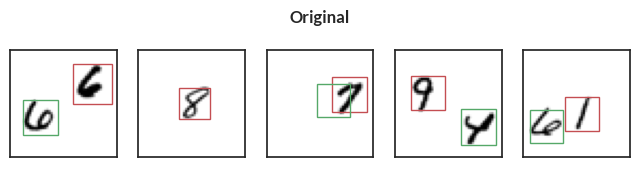

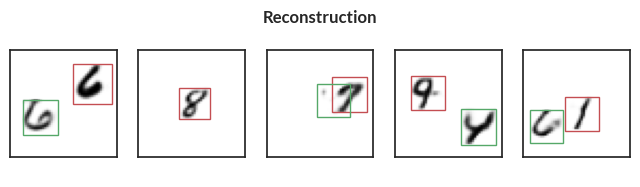

Epoch=191, total_epoch_step_time=292.77, loss=629.12
Epoch=192, total_epoch_step_time=294.34, loss=630.29
Epoch=193, total_epoch_step_time=295.83, loss=630.72
Epoch=194, total_epoch_step_time=297.34, loss=631.38
Epoch=195, total_epoch_step_time=298.93, loss=631.36
Epoch=196, total_epoch_step_time=300.50, loss=631.34
Epoch=197, total_epoch_step_time=301.99, loss=632.02
Epoch=198, total_epoch_step_time=303.54, loss=631.88
Epoch=199, total_epoch_step_time=304.97, loss=631.81
Epoch=200, total_epoch_step_time=306.52, loss=631.59
accuracy=0.9668499827384949, counts=[[19935    13     0     0]
 [   19 19231   770     0]
 [    4  1167 18845    16]]


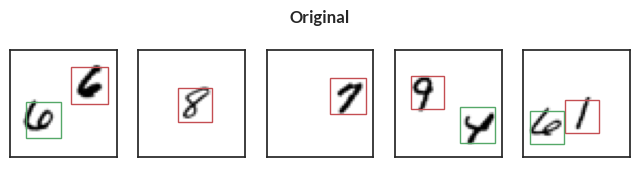

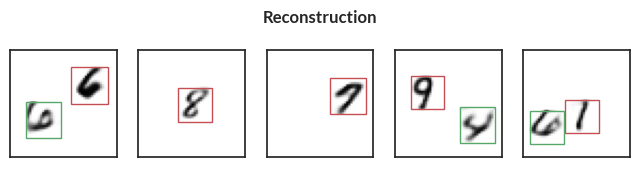

In [17]:
key, sub_key = jax.random.split(key)
losses, accuracy, wall_clock_times, params = train(sub_key, n=1, num_epochs=200)

In [18]:
arr = np.array([losses, accuracy, wall_clock_times])
df = pd.DataFrame(arr.T, columns=["ELBO Loss", "Accuracy", "Epoch wall clock times"])
df.to_csv("./training_runs/grasp_reinforce_epochs_201_mccoy_prior.csv", index=False)

Epoch=0, total_epoch_step_time=2.19, loss=240.35
accuracy=0.2502833306789398, counts=[[11340  6717  1682   209]
 [16106  3603   297    14]
 [18185  1772    74     1]]


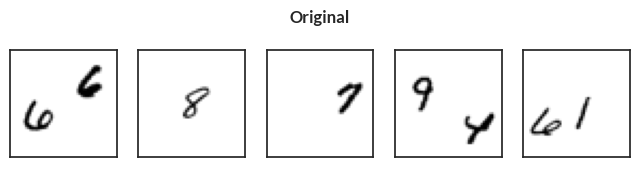

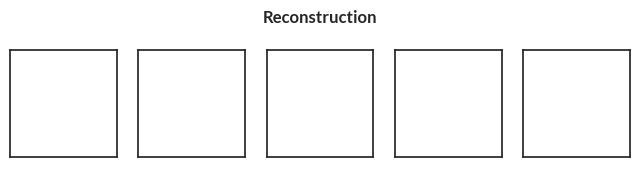

Epoch=1, total_epoch_step_time=4.31, loss=425.55
Epoch=2, total_epoch_step_time=6.42, loss=445.18
Epoch=3, total_epoch_step_time=8.58, loss=458.45
Epoch=4, total_epoch_step_time=10.70, loss=466.89
Epoch=5, total_epoch_step_time=12.87, loss=482.02
Epoch=6, total_epoch_step_time=15.05, loss=503.99
Epoch=7, total_epoch_step_time=17.18, loss=518.53
Epoch=8, total_epoch_step_time=19.37, loss=527.87
Epoch=9, total_epoch_step_time=21.53, loss=538.66
Epoch=10, total_epoch_step_time=23.70, loss=547.79
accuracy=0.6567333340644836, counts=[[12381  6603   912    52]
 [ 1690 14073  4093   164]
 [  341  5124 12950  1617]]


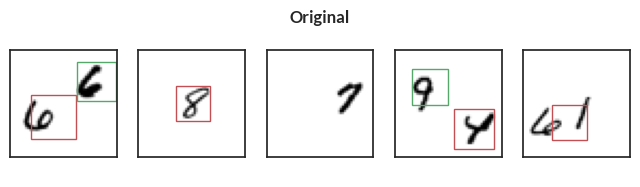

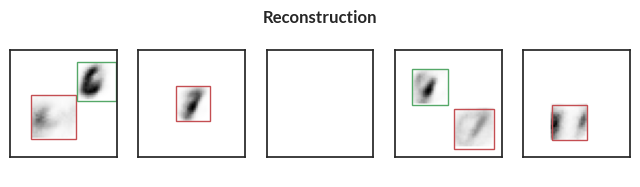

Epoch=11, total_epoch_step_time=25.88, loss=557.18
Epoch=12, total_epoch_step_time=28.01, loss=564.21
Epoch=13, total_epoch_step_time=30.18, loss=569.19
Epoch=14, total_epoch_step_time=32.37, loss=573.46
Epoch=15, total_epoch_step_time=34.48, loss=576.93
Epoch=16, total_epoch_step_time=36.62, loss=579.89
Epoch=17, total_epoch_step_time=38.80, loss=583.33
Epoch=18, total_epoch_step_time=40.93, loss=586.52
Epoch=19, total_epoch_step_time=43.15, loss=588.28
Epoch=20, total_epoch_step_time=45.45, loss=590.41
accuracy=0.7911666631698608, counts=[[15206  4610   132     0]
 [  939 15419  3638    24]
 [   75  2553 16845   559]]


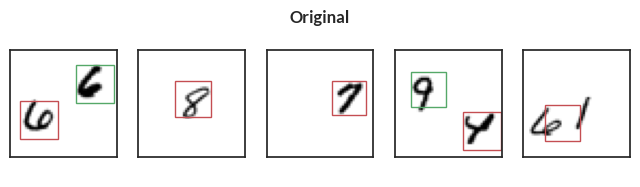

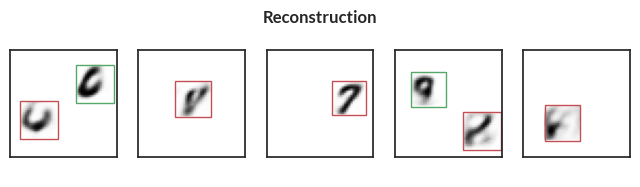

Epoch=21, total_epoch_step_time=47.67, loss=592.92
Epoch=22, total_epoch_step_time=49.98, loss=595.06
Epoch=23, total_epoch_step_time=52.31, loss=596.93
Epoch=24, total_epoch_step_time=54.55, loss=599.09
Epoch=25, total_epoch_step_time=56.75, loss=601.41
Epoch=26, total_epoch_step_time=58.93, loss=601.53
Epoch=27, total_epoch_step_time=61.12, loss=603.49
Epoch=28, total_epoch_step_time=63.55, loss=604.89
Epoch=29, total_epoch_step_time=65.77, loss=605.93
Epoch=30, total_epoch_step_time=67.96, loss=606.01
accuracy=0.8593500256538391, counts=[[17073  2848    27     0]
 [  515 17430  2070     5]
 [   21  2609 17058   344]]


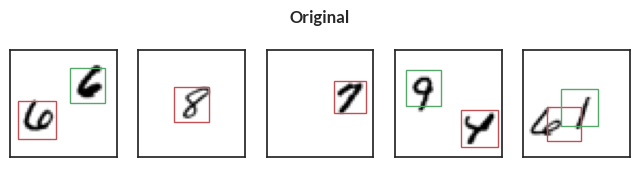

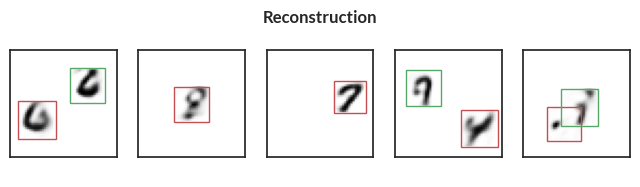

Epoch=31, total_epoch_step_time=70.12, loss=606.71
Epoch=32, total_epoch_step_time=72.41, loss=607.67
Epoch=33, total_epoch_step_time=74.57, loss=607.43
Epoch=34, total_epoch_step_time=76.77, loss=609.24
Epoch=35, total_epoch_step_time=79.04, loss=610.04
Epoch=36, total_epoch_step_time=81.23, loss=610.08
Epoch=37, total_epoch_step_time=83.40, loss=610.47
Epoch=38, total_epoch_step_time=85.58, loss=611.16
Epoch=39, total_epoch_step_time=87.75, loss=611.78
Epoch=40, total_epoch_step_time=89.94, loss=611.55
accuracy=0.8681166768074036, counts=[[17311  2626    11     0]
 [  337 16235  3442     6]
 [   17  1217 18541   257]]


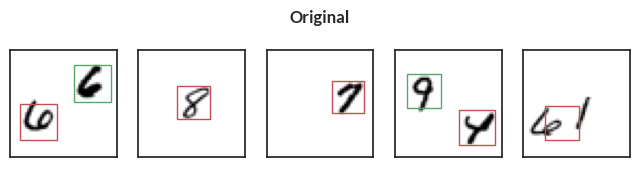

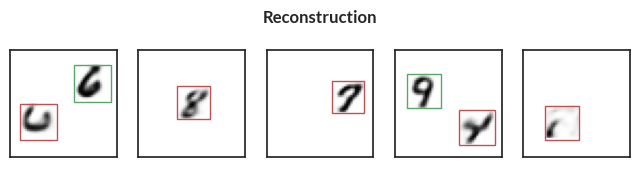

Epoch=41, total_epoch_step_time=92.11, loss=612.49
Epoch=42, total_epoch_step_time=94.29, loss=611.76
Epoch=43, total_epoch_step_time=96.45, loss=614.13
Epoch=44, total_epoch_step_time=98.63, loss=614.21
Epoch=45, total_epoch_step_time=100.80, loss=614.53
Epoch=46, total_epoch_step_time=102.98, loss=615.80
Epoch=47, total_epoch_step_time=105.14, loss=616.19
Epoch=48, total_epoch_step_time=107.31, loss=616.14
Epoch=49, total_epoch_step_time=109.46, loss=616.33
Epoch=50, total_epoch_step_time=111.63, loss=616.03
accuracy=0.885116696357727, counts=[[18437  1511     0     0]
 [  380 18981   658     1]
 [    7  4319 15689    17]]


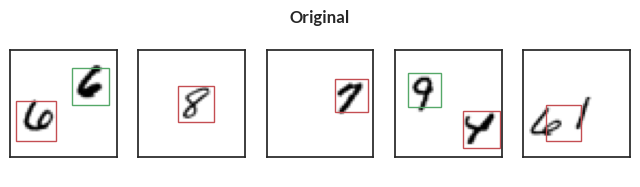

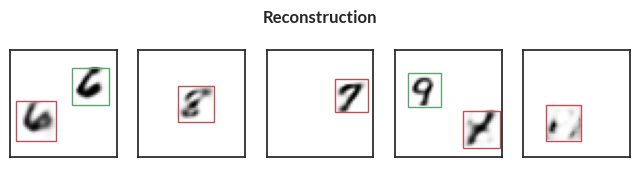

Epoch=51, total_epoch_step_time=113.84, loss=616.56
Epoch=52, total_epoch_step_time=116.01, loss=616.78
Epoch=53, total_epoch_step_time=118.17, loss=617.77
Epoch=54, total_epoch_step_time=120.34, loss=618.81
Epoch=55, total_epoch_step_time=122.49, loss=618.58
Epoch=56, total_epoch_step_time=124.69, loss=618.63
Epoch=57, total_epoch_step_time=126.88, loss=619.73
Epoch=58, total_epoch_step_time=129.05, loss=619.72
Epoch=59, total_epoch_step_time=131.21, loss=619.84
Epoch=60, total_epoch_step_time=133.42, loss=620.92
accuracy=0.8903999924659729, counts=[[18009  1937     2     0]
 [  261 16421  3336     2]
 [    7   977 18994    54]]


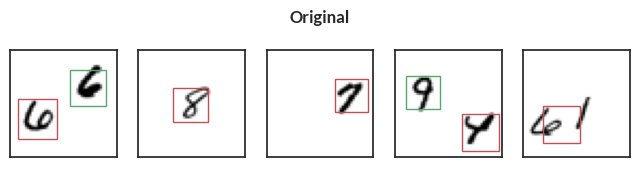

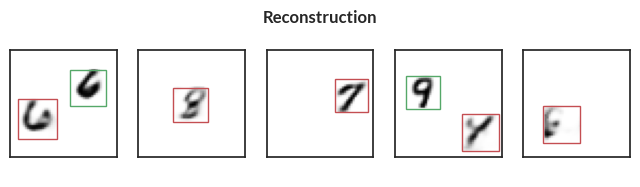

Epoch=61, total_epoch_step_time=135.57, loss=620.00
Epoch=62, total_epoch_step_time=137.73, loss=619.61
Epoch=63, total_epoch_step_time=139.89, loss=619.76
Epoch=64, total_epoch_step_time=142.06, loss=619.15
Epoch=65, total_epoch_step_time=144.23, loss=621.36
Epoch=66, total_epoch_step_time=146.39, loss=621.14
Epoch=67, total_epoch_step_time=148.55, loss=621.47
Epoch=68, total_epoch_step_time=150.71, loss=621.83
Epoch=69, total_epoch_step_time=152.91, loss=622.11
Epoch=70, total_epoch_step_time=155.07, loss=620.86
accuracy=0.9154333472251892, counts=[[18789  1159     0     0]
 [  208 17537  2273     2]
 [    4  1393 18600    35]]


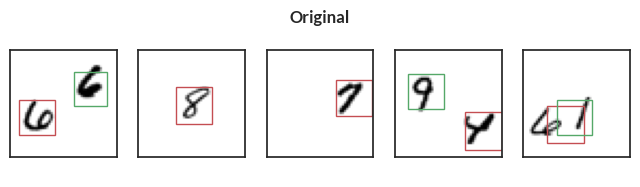

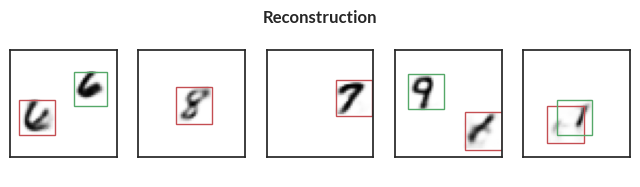

Epoch=71, total_epoch_step_time=157.23, loss=623.07
Epoch=72, total_epoch_step_time=159.40, loss=623.33
Epoch=73, total_epoch_step_time=161.56, loss=623.10
Epoch=74, total_epoch_step_time=163.76, loss=622.78
Epoch=75, total_epoch_step_time=166.07, loss=622.57
Epoch=76, total_epoch_step_time=168.56, loss=623.43
Epoch=77, total_epoch_step_time=171.06, loss=623.58
Epoch=78, total_epoch_step_time=173.61, loss=623.78
Epoch=79, total_epoch_step_time=175.84, loss=622.18
Epoch=80, total_epoch_step_time=178.17, loss=624.27
accuracy=0.9325667023658752, counts=[[19220   727     1     0]
 [  237 18372  1411     0]
 [    5  1641 18362    24]]


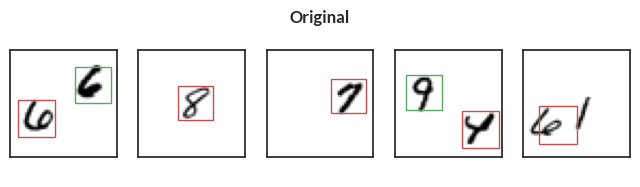

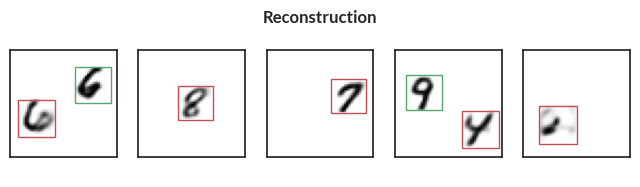

Epoch=81, total_epoch_step_time=180.27, loss=624.62
Epoch=82, total_epoch_step_time=182.48, loss=625.07
Epoch=83, total_epoch_step_time=184.70, loss=624.63
Epoch=84, total_epoch_step_time=186.81, loss=624.58
Epoch=85, total_epoch_step_time=188.99, loss=625.17
Epoch=86, total_epoch_step_time=191.31, loss=625.18
Epoch=87, total_epoch_step_time=193.49, loss=624.56
Epoch=88, total_epoch_step_time=195.83, loss=624.09
Epoch=89, total_epoch_step_time=198.07, loss=624.33
Epoch=90, total_epoch_step_time=200.29, loss=624.53
accuracy=0.926966667175293, counts=[[19198   750     0     0]
 [  170 17881  1969     0]
 [    5  1473 18539    15]]


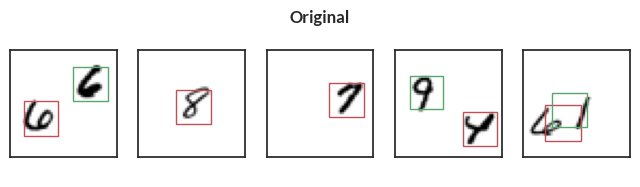

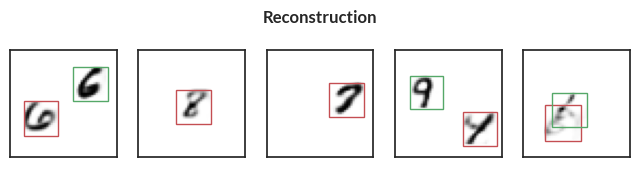

Epoch=91, total_epoch_step_time=202.62, loss=625.11
Epoch=92, total_epoch_step_time=205.21, loss=625.25
Epoch=93, total_epoch_step_time=207.84, loss=624.64
Epoch=94, total_epoch_step_time=210.41, loss=623.80
Epoch=95, total_epoch_step_time=213.04, loss=623.83
Epoch=96, total_epoch_step_time=215.31, loss=624.29
Epoch=97, total_epoch_step_time=217.64, loss=624.55
Epoch=98, total_epoch_step_time=219.77, loss=624.96
Epoch=99, total_epoch_step_time=221.96, loss=624.74
Epoch=100, total_epoch_step_time=224.17, loss=624.22
accuracy=0.9255666732788086, counts=[[19303   645     0     0]
 [  129 17312  2577     2]
 [    6  1083 18919    24]]


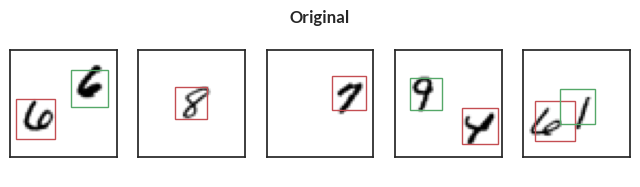

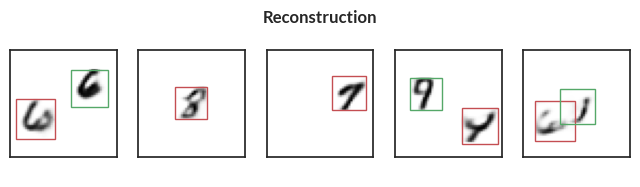

Epoch=101, total_epoch_step_time=226.40, loss=624.66
Epoch=102, total_epoch_step_time=228.62, loss=625.57
Epoch=103, total_epoch_step_time=230.78, loss=625.98
Epoch=104, total_epoch_step_time=233.35, loss=626.06
Epoch=105, total_epoch_step_time=235.98, loss=626.74
Epoch=106, total_epoch_step_time=238.18, loss=627.07
Epoch=107, total_epoch_step_time=240.51, loss=625.76
Epoch=108, total_epoch_step_time=242.78, loss=626.20
Epoch=109, total_epoch_step_time=245.38, loss=626.86
Epoch=110, total_epoch_step_time=247.75, loss=627.11
accuracy=0.9387666583061218, counts=[[19299   649     0     0]
 [   94 18073  1851     2]
 [    4  1061 18954    13]]


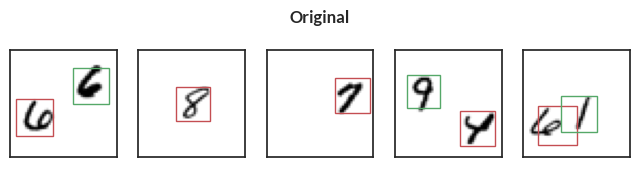

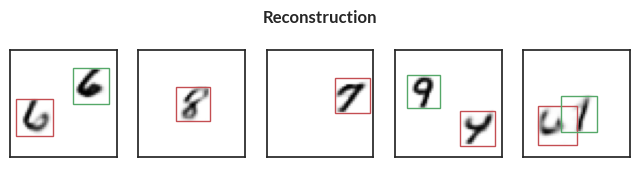

Epoch=111, total_epoch_step_time=250.03, loss=625.48
Epoch=112, total_epoch_step_time=252.31, loss=626.88
Epoch=113, total_epoch_step_time=254.73, loss=626.82
Epoch=114, total_epoch_step_time=257.20, loss=627.44
Epoch=115, total_epoch_step_time=259.51, loss=626.98
Epoch=116, total_epoch_step_time=261.88, loss=627.45
Epoch=117, total_epoch_step_time=264.18, loss=627.90
Epoch=118, total_epoch_step_time=266.35, loss=628.26
Epoch=119, total_epoch_step_time=268.49, loss=628.19
Epoch=120, total_epoch_step_time=270.73, loss=627.68
accuracy=0.9238166809082031, counts=[[19411   537     0     0]
 [  177 18947   895     1]
 [    5  2946 17071    10]]


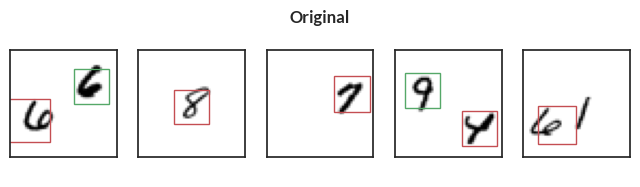

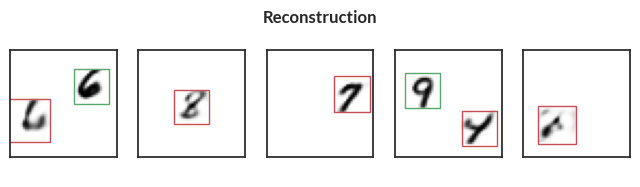

Epoch=121, total_epoch_step_time=272.87, loss=627.95
Epoch=122, total_epoch_step_time=275.05, loss=628.52
Epoch=123, total_epoch_step_time=277.22, loss=628.31
Epoch=124, total_epoch_step_time=279.34, loss=629.09
Epoch=125, total_epoch_step_time=281.55, loss=628.75
Epoch=126, total_epoch_step_time=283.70, loss=628.27
Epoch=127, total_epoch_step_time=285.91, loss=628.47
Epoch=128, total_epoch_step_time=288.03, loss=628.94
Epoch=129, total_epoch_step_time=290.25, loss=629.14
Epoch=130, total_epoch_step_time=292.39, loss=628.74
accuracy=0.9127333164215088, counts=[[19317   631     0     0]
 [  140 16222  3652     6]
 [    4   776 19225    27]]


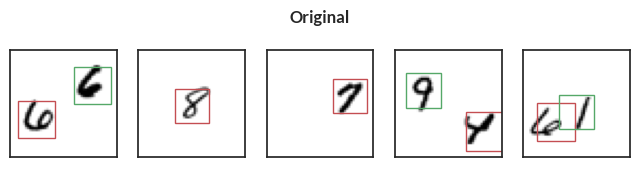

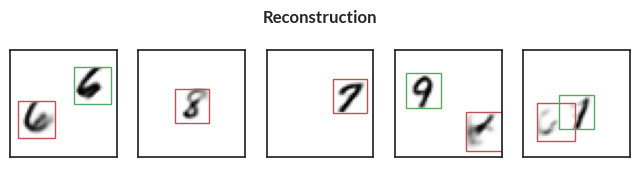

Epoch=131, total_epoch_step_time=294.69, loss=628.23
Epoch=132, total_epoch_step_time=296.98, loss=627.43
Epoch=133, total_epoch_step_time=299.37, loss=628.17
Epoch=134, total_epoch_step_time=301.64, loss=627.72
Epoch=135, total_epoch_step_time=303.95, loss=628.96
Epoch=136, total_epoch_step_time=306.27, loss=629.11
Epoch=137, total_epoch_step_time=308.60, loss=628.73
Epoch=138, total_epoch_step_time=310.86, loss=629.27
Epoch=139, total_epoch_step_time=313.21, loss=629.86
Epoch=140, total_epoch_step_time=315.59, loss=630.08
accuracy=0.9413999915122986, counts=[[19433   515     0     0]
 [   97 18245  1677     1]
 [    5  1207 18806    14]]


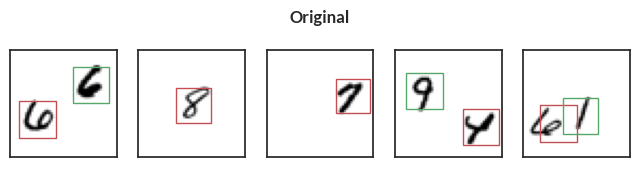

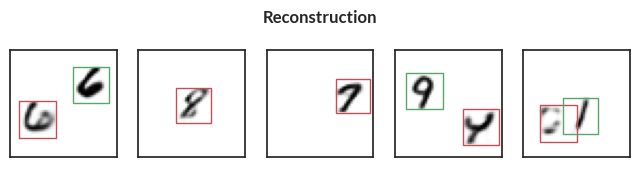

Epoch=141, total_epoch_step_time=318.19, loss=630.23
Epoch=142, total_epoch_step_time=320.64, loss=629.81
Epoch=143, total_epoch_step_time=323.12, loss=629.89
Epoch=144, total_epoch_step_time=325.50, loss=629.43
Epoch=145, total_epoch_step_time=327.92, loss=628.72
Epoch=146, total_epoch_step_time=330.30, loss=627.56
Epoch=147, total_epoch_step_time=332.72, loss=627.99
Epoch=148, total_epoch_step_time=335.21, loss=628.67
Epoch=149, total_epoch_step_time=337.59, loss=629.48
Epoch=150, total_epoch_step_time=340.03, loss=629.92
accuracy=0.9424833655357361, counts=[[19481   466     1     0]
 [   99 18192  1728     1]
 [    1  1108 18876    47]]


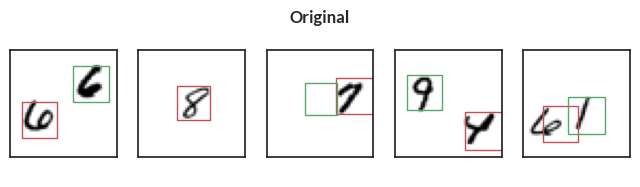

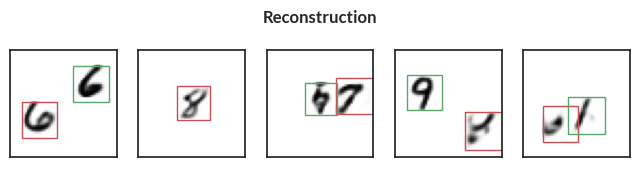

Epoch=151, total_epoch_step_time=342.41, loss=630.47
Epoch=152, total_epoch_step_time=344.84, loss=630.19
Epoch=153, total_epoch_step_time=347.22, loss=630.29
Epoch=154, total_epoch_step_time=349.59, loss=629.53
Epoch=155, total_epoch_step_time=351.91, loss=628.94
Epoch=156, total_epoch_step_time=354.30, loss=631.22
Epoch=157, total_epoch_step_time=356.70, loss=631.26
Epoch=158, total_epoch_step_time=359.15, loss=630.75
Epoch=159, total_epoch_step_time=361.60, loss=630.64
Epoch=160, total_epoch_step_time=364.02, loss=630.35
accuracy=0.9334666728973389, counts=[[19244   704     0     0]
 [   57 17695  2267     1]
 [    3   926 19069    34]]


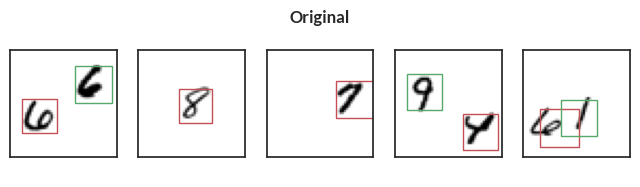

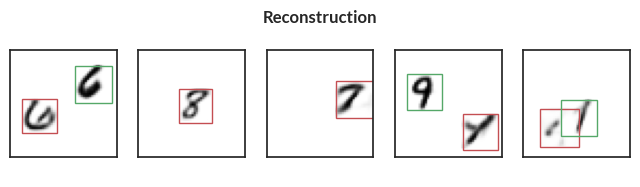

Epoch=161, total_epoch_step_time=366.36, loss=630.49
Epoch=162, total_epoch_step_time=368.79, loss=630.97
Epoch=163, total_epoch_step_time=371.14, loss=630.61
Epoch=164, total_epoch_step_time=373.52, loss=630.04
Epoch=165, total_epoch_step_time=375.89, loss=630.56
Epoch=166, total_epoch_step_time=378.26, loss=631.05
Epoch=167, total_epoch_step_time=380.70, loss=630.99
Epoch=168, total_epoch_step_time=383.08, loss=630.36
Epoch=169, total_epoch_step_time=385.46, loss=630.88
Epoch=170, total_epoch_step_time=387.88, loss=631.31
accuracy=0.9362333416938782, counts=[[19443   505     0     0]
 [   69 17635  2315     1]
 [    4   910 19096    22]]


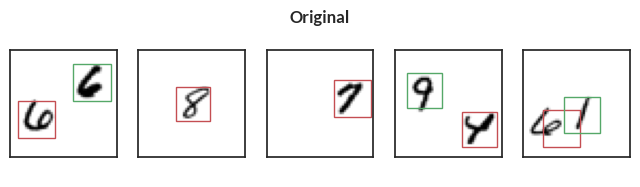

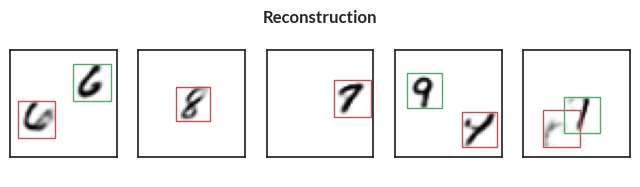

Epoch=171, total_epoch_step_time=390.33, loss=630.22
Epoch=172, total_epoch_step_time=392.73, loss=629.27
Epoch=173, total_epoch_step_time=395.18, loss=631.92
Epoch=174, total_epoch_step_time=397.59, loss=631.83
Epoch=175, total_epoch_step_time=399.99, loss=631.46
Epoch=176, total_epoch_step_time=402.45, loss=631.40
Epoch=177, total_epoch_step_time=404.87, loss=631.06
Epoch=178, total_epoch_step_time=407.30, loss=630.66
Epoch=179, total_epoch_step_time=409.72, loss=631.32
Epoch=180, total_epoch_step_time=412.13, loss=631.60
accuracy=0.9452666640281677, counts=[[19426   522     0     0]
 [   79 18229  1711     1]
 [    5   952 19061    14]]


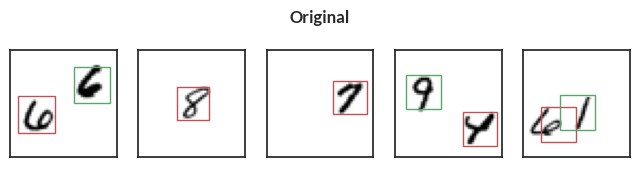

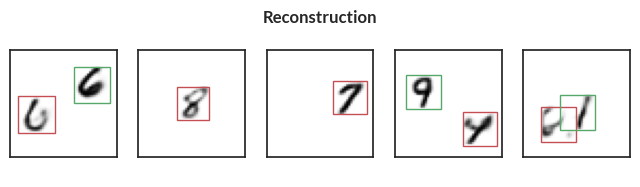

Epoch=181, total_epoch_step_time=414.50, loss=631.02
Epoch=182, total_epoch_step_time=416.88, loss=630.78
Epoch=183, total_epoch_step_time=419.34, loss=629.56
Epoch=184, total_epoch_step_time=421.71, loss=630.30
Epoch=185, total_epoch_step_time=424.13, loss=631.03
Epoch=186, total_epoch_step_time=426.49, loss=631.00
Epoch=187, total_epoch_step_time=428.87, loss=631.20
Epoch=188, total_epoch_step_time=431.24, loss=630.27
Epoch=189, total_epoch_step_time=433.58, loss=631.00
Epoch=190, total_epoch_step_time=436.01, loss=630.50
accuracy=0.9377166628837585, counts=[[19590   358     0     0]
 [   87 18583  1349     1]
 [    2  1926 18090    14]]


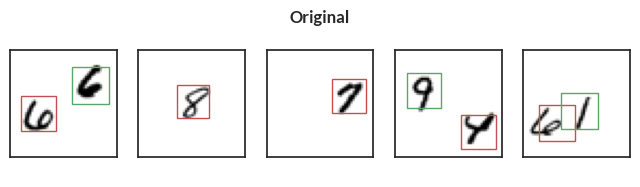

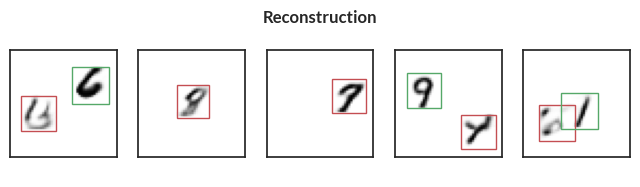

Epoch=191, total_epoch_step_time=438.40, loss=631.68
Epoch=192, total_epoch_step_time=440.78, loss=631.30
Epoch=193, total_epoch_step_time=443.18, loss=632.19
Epoch=194, total_epoch_step_time=445.57, loss=632.34
Epoch=195, total_epoch_step_time=447.90, loss=631.83
Epoch=196, total_epoch_step_time=450.26, loss=632.08
Epoch=197, total_epoch_step_time=452.63, loss=631.88
Epoch=198, total_epoch_step_time=454.97, loss=632.38
Epoch=199, total_epoch_step_time=457.36, loss=632.65
Epoch=200, total_epoch_step_time=459.73, loss=632.02
accuracy=0.9508500099182129, counts=[[19717   231     0     0]
 [   82 18014  1923     1]
 [    3   691 19320    18]]


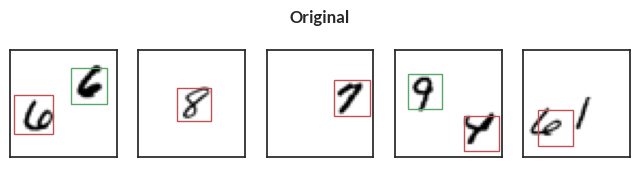

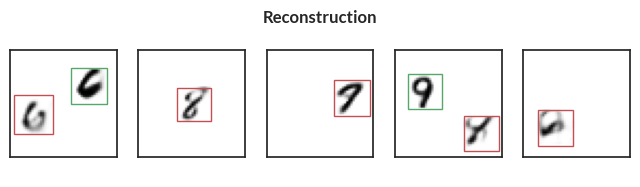

In [21]:
key, sub_key = jax.random.split(key)
losses, accuracy, wall_clock_times, params = train(
    sub_key, n=2, num_epochs=200, learning_rate=1.0e-4
)

In [22]:
arr = np.array([losses, accuracy, wall_clock_times])
df = pd.DataFrame(arr.T, columns=["ELBO Loss", "Accuracy", "Epoch wall clock times"])
df.to_csv(
    "./training_runs/grasp_iwae_n_2_reinforce_epochs_201_mccoy_prior.csv", index=False
)